In [8]:
#Choose a Dataset
#Use a pre-annotated dataset for object detection:
#COCO Dataset: Common Objects in Context (80 classes)
#Pascal VOC
#Custom dataset (optional) with annotations in YOLO or COCO format
#from ultralytics import YOLO #How to import a database
#pip install ultralytics


#Install Required Libraries
#pip install opencv-python matplotlib
#pip install tensorflow tensorflow-hub opencv-python matplotlib
#pip install tensorflow scikit-learn opencv-python gTTS




In [36]:
#Import Libraries
import os
import random
import requests
import torch
from PIL import Image
from torch.utils.data import DataLoader

from pathlib import Path

In [43]:
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer


from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)



In [ ]:
#  Simple configuration class for creating the data set
class config:
    
    # Trainer params
    CHECKPOINT_DIR = './.ipynb_checkpoints' # Saves checkpoints

    EXPERIMENT_NAME = 'race_number' # Name of the experiment
    
    # Dataset params
    DATA_DIR = './input' # The data directory
    
    # Training set
    TRAIN_IMAGES_DIR =  './train_images' # Train images folder
    TRAIN_LABELS_DIR = "./train_labels" # Train labels folder

    # Validation
    VAL_IMAGES_DIR = './val_images' # Validation images folder
    VAL_LABELS_DIR = './val_labels' # Validation labels folder (array of points)
    
    # Test set
    TEST_IMAGES_DIR = './test_images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = './test_labels' #child dir of DATA_DIR where test labels are (array of points)

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    # Dataloader params
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # Model params
    MODEL_NAME = "yolo_nas_l"
    CHECKPOINT_PATH = "model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth"



# Load your YOLO-NAS model manually with your checkpoint path
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path="model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth",
    load_backbone=True

)
#Test
# Set the model to evaluation mode
model.eval()



YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

[2025-04-28 13:41:29] INFO - checkpoint_utils.py - Successfully loaded model's backbone weights from model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth checkpoint.


In [39]:
# Test model with a dummy input
dummy_input = torch.randn(1, 3, 640, 640)

# Run the dummy input through the model
output = model(dummy_input)

print("Model output:", output)


Model output: ((tensor([[[-59.9040, -60.0145,  67.7829,  67.5380],
         [-51.7744, -59.7367,  75.7505,  67.7445],
         [-43.7523, -59.7945,  83.6756,  67.7908],
         ...,
         [304.1433, 369.4566, 815.4775, 880.6699],
         [336.1437, 369.4570, 847.4799, 880.6736],
         [368.1836, 369.4513, 879.5035, 880.6724]]], grad_fn=<MulBackward0>), tensor([[[0.0102, 0.0096, 0.0100],
         [0.0102, 0.0095, 0.0100],
         [0.0100, 0.0097, 0.0100],
         ...,
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100]]], grad_fn=<SigmoidBackward0>)), (tensor([[[-4.5743, -4.6317, -4.5944],
         [-4.5794, -4.6452, -4.5932],
         [-4.5997, -4.6255, -4.5918],
         ...,
         [-4.5938, -4.5937, -4.5937],
         [-4.5941, -4.5937, -4.5938],
         [-4.5931, -4.5949, -4.5950]]], grad_fn=<PermuteBackward0>), tensor([[[-0.0084,  0.0759,  0.0294,  ..., -0.0220, -0.0384, -0.0538],
         [-0.0215,  0.0587,  0.0579,

[2025-04-28 13:41:37] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 16/16 [00:00<00:00, 843.66it/s]
[2025-04-28 13:41:37] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 8/8 [00:00<00:00, 693.33it/s]
[2025-04-28 13:41:37] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 229.76it/s]
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\visualization\utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplo

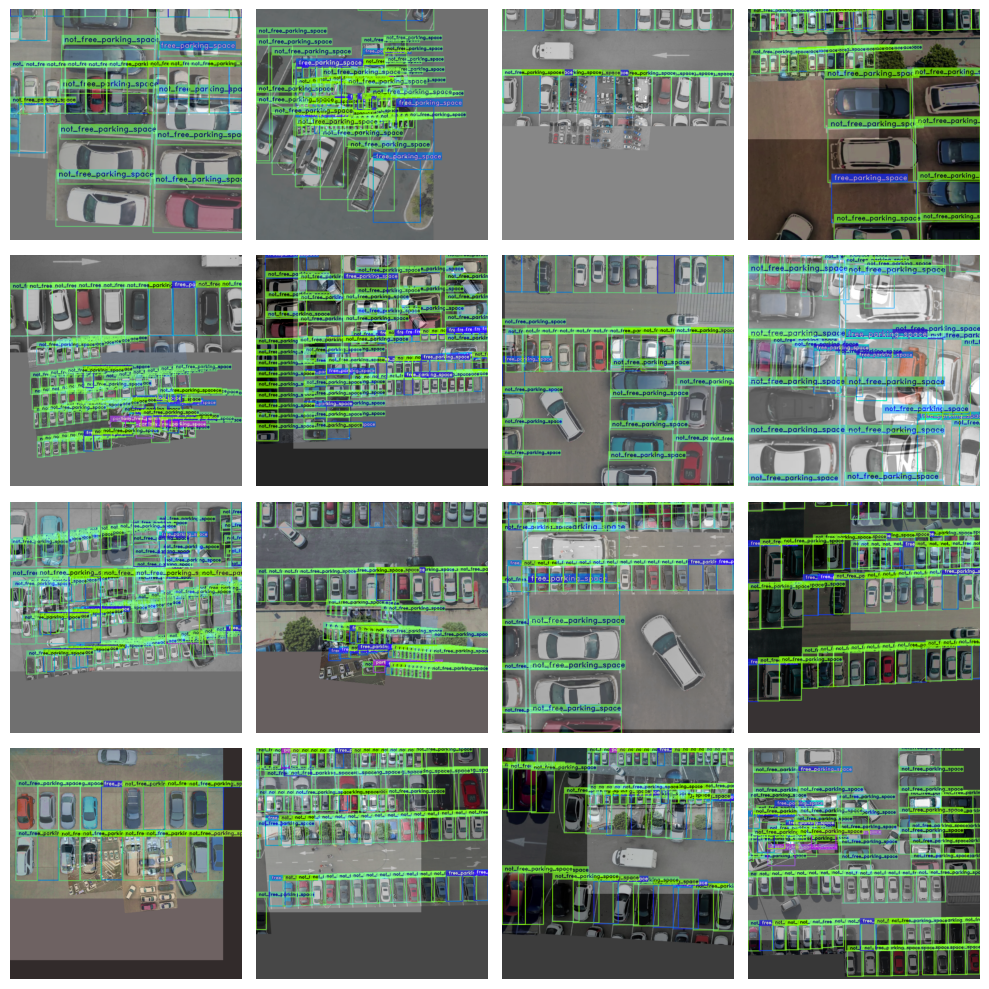

In [40]:
# Creating the dataset
# Split the datat into train, test, and validation sets
# The training dataset
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The validation data set
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The test data set
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot() # Visualize the test images with plotting




In [76]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
# Create the trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# Define the post prediction callback
post_prediction_callback = PPYoloEPostPredictionCallback(
    score_threshold=0.25,    
    nms_threshold=0.7,      
    nms_top_k=300,          
    max_predictions=100      # maximum predictions per image
)

# Define the training parameters
train_params = {
    "max_epochs": 10,          
    "early_stopping_patience": 5,  # if no val improvement for 5 epochs, stop
    "initial_lr": 5e-4,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "train_loader": train_data,
    "valid_loader": val_data,
    "loss": PPYoloELoss(num_classes=config.NUM_CLASSES, use_static_assigner=False),
    "metric_to_watch": "mAP@0.50",
    "valid_metrics_list": [
        DetectionMetrics_050(
            num_cls=config.NUM_CLASSES,
            post_prediction_callback=post_prediction_callback
        )
    ],
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "warmup_epochs": 3,
    "average_best_models": False,  
}

# Start training
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)


[2025-04-28 14:39:40] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250428_143940_403925`
[2025-04-28 14:39:40] INFO - sg_trainer.py - Checkpoints directory: ..//ipynb_checkpoints\race_number\RUN_20250428_143940_403925
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 

The console stream is now moved to ..//ipynb_checkpoints\race_number\RUN_20250428_143940_403925/console_Apr28_14_39_40.txt


[2025-04-28 14:40:26] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            16         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         4          (len(train_loader))
    - Gradient updates per epoch:   4          (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0005 (66.91M parameters) WD: 0.0, (66.91M parameters)

[2025-04-28 14:40:26] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Train epoch 0:   

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9463
│   ├── Ppyoloeloss/loss_iou = 0.8277
│   ├── Ppyoloeloss/loss_dfl = 0.9263
│   └── Ppyoloeloss/loss = 2.7004
└── Validation
    ├── Ppyoloeloss/loss_cls = 35166.1
    ├── Ppyoloeloss/loss_iou = 1.1948
    ├── Ppyoloeloss/loss_dfl = 295.9196
    ├── Ppyoloeloss/loss = 35463.215
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.0



Validating epoch 1: 100%|██████████| 2/2 [00:33<00:00, 16.60s/it]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.948
│   │   ├── Epoch N-1      = 0.9463 (↗ 0.0016)
│   │   └── Best until now = 0.9463 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.8377
│   │   ├── Epoch N-1      = 0.8277 (↗ 0.01)
│   │   └── Best until now = 0.8277 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.9274
│   │   ├── Epoch N-1      = 0.9263 (↗ 0.001)
│   │   └── Best until now = 0.9263 (↗ 0.001)
│   └── Ppyoloeloss/loss = 2.713
│       ├── Epoch N-1      = 2.7004 (↗ 0.0127)
│       └── Best until now = 2.7004 (↗ 0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 66068.19
    │   ├── Epoch N-1      = 35166.1 (↗ 30902.086)
    │   └── Best until now = 35166.1 (↗ 30902.086)
    ├── Ppyoloeloss/loss_iou = 1.1349
    │   ├── Epoch N-1      = 1.1948 (↘ -0.06)
    │   └── Best until now = 1.1948 (↘ -0.06)
    ├── Ppyoloeloss/loss_dfl = 518.2386
    │   ├── Epoch N-1      = 295.9196 (↗ 222.319)
    │   └── Best until now = 295.9196 (↗ 222.319)
    ├── Ppyoloeloss/loss = 6

Validating epoch 2: 100%|██████████| 2/2 [00:34<00:00, 17.22s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9867
│   │   ├── Epoch N-1      = 0.948  (↗ 0.0387)
│   │   └── Best until now = 0.9463 (↗ 0.0403)
│   ├── Ppyoloeloss/loss_iou = 0.774
│   │   ├── Epoch N-1      = 0.8377 (↘ -0.0637)
│   │   └── Best until now = 0.8277 (↘ -0.0537)
│   ├── Ppyoloeloss/loss_dfl = 0.9203
│   │   ├── Epoch N-1      = 0.9274 (↘ -0.007)
│   │   └── Best until now = 0.9263 (↘ -0.006)
│   └── Ppyoloeloss/loss = 2.681
│       ├── Epoch N-1      = 2.713  (↘ -0.032)
│       └── Best until now = 2.7004 (↘ -0.0194)
└── Validation
    ├── Ppyoloeloss/loss_cls = 26329.727
    │   ├── Epoch N-1      = 66068.19 (↘ -39738.46)
    │   └── Best until now = 35166.1 (↘ -8836.375)
    ├── Ppyoloeloss/loss_iou = 1.1466
    │   ├── Epoch N-1      = 1.1349 (↗ 0.0117)
    │   └── Best until now = 1.1349 (↗ 0.0117)
    ├── Ppyoloeloss/loss_dfl = 142.3758
    │   ├── Epoch N-1      = 518.2386 (↘ -375.8627)
    │   └── Best until now = 295.9196 (↘ -153.5437)
    ├── Ppy

Validating epoch 3: 100%|██████████| 2/2 [00:32<00:00, 16.26s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8774
│   │   ├── Epoch N-1      = 0.9867 (↘ -0.1092)
│   │   └── Best until now = 0.9463 (↘ -0.0689)
│   ├── Ppyoloeloss/loss_iou = 0.7609
│   │   ├── Epoch N-1      = 0.774  (↘ -0.013)
│   │   └── Best until now = 0.774  (↘ -0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.8014
│   │   ├── Epoch N-1      = 0.9203 (↘ -0.1189)
│   │   └── Best until now = 0.9203 (↘ -0.1189)
│   └── Ppyoloeloss/loss = 2.4398
│       ├── Epoch N-1      = 2.681  (↘ -0.2412)
│       └── Best until now = 2.681  (↘ -0.2412)
└── Validation
    ├── Ppyoloeloss/loss_cls = 6599.583
    │   ├── Epoch N-1      = 26329.727 (↘ -19730.145)
    │   └── Best until now = 26329.727 (↘ -19730.145)
    ├── Ppyoloeloss/loss_iou = 1.1675
    │   ├── Epoch N-1      = 1.1466 (↗ 0.0209)
    │   └── Best until now = 1.1349 (↗ 0.0327)
    ├── Ppyoloeloss/loss_dfl = 29.4158
    │   ├── Epoch N-1      = 142.3758 (↘ -112.9601)
    │   └── Best until now = 142.3758 (↘ -112.9601)
   

Validating epoch 4: 100%|██████████| 2/2 [00:34<00:00, 17.01s/it]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9395
│   │   ├── Epoch N-1      = 0.8774 (↗ 0.0621)
│   │   └── Best until now = 0.8774 (↗ 0.0621)
│   ├── Ppyoloeloss/loss_iou = 0.775
│   │   ├── Epoch N-1      = 0.7609 (↗ 0.0141)
│   │   └── Best until now = 0.7609 (↗ 0.0141)
│   ├── Ppyoloeloss/loss_dfl = 0.8579
│   │   ├── Epoch N-1      = 0.8014 (↗ 0.0565)
│   │   └── Best until now = 0.8014 (↗ 0.0565)
│   └── Ppyoloeloss/loss = 2.5725
│       ├── Epoch N-1      = 2.4398 (↗ 0.1327)
│       └── Best until now = 2.4398 (↗ 0.1327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.3164
    │   ├── Epoch N-1      = 6599.583 (↘ -6596.2666)
    │   └── Best until now = 6599.583 (↘ -6596.2666)
    ├── Ppyoloeloss/loss_iou = 1.1206
    │   ├── Epoch N-1      = 1.1675 (↘ -0.047)
    │   └── Best until now = 1.1349 (↘ -0.0143)
    ├── Ppyoloeloss/loss_dfl = 1.0348
    │   ├── Epoch N-1      = 29.4158 (↘ -28.381)
    │   └── Best until now = 29.4158 (↘ -28.381)
    ├── Ppyoloeloss/

Validating epoch 5: 100%|██████████| 2/2 [00:36<00:00, 18.09s/it]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9403
│   │   ├── Epoch N-1      = 0.9395 (↗ 0.0008)
│   │   └── Best until now = 0.8774 (↗ 0.0629)
│   ├── Ppyoloeloss/loss_iou = 0.7583
│   │   ├── Epoch N-1      = 0.775  (↘ -0.0167)
│   │   └── Best until now = 0.7609 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.8499
│   │   ├── Epoch N-1      = 0.8579 (↘ -0.0081)
│   │   └── Best until now = 0.8014 (↗ 0.0485)
│   └── Ppyoloeloss/loss = 2.5485
│       ├── Epoch N-1      = 2.5725 (↘ -0.024)
│       └── Best until now = 2.4398 (↗ 0.1087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.418
    │   ├── Epoch N-1      = 3.3164 (↘ -1.8984)
    │   └── Best until now = 3.3164 (↘ -1.8984)
    ├── Ppyoloeloss/loss_iou = 1.242
    │   ├── Epoch N-1      = 1.1206 (↗ 0.1214)
    │   └── Best until now = 1.1206 (↗ 0.1214)
    ├── Ppyoloeloss/loss_dfl = 1.0631
    │   ├── Epoch N-1      = 1.0348 (↗ 0.0283)
    │   └── Best until now = 1.0348 (↗ 0.0283)
    ├── Ppyoloeloss/loss = 3.723


Validating epoch 6: 100%|██████████| 2/2 [00:30<00:00, 15.48s/it]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8741
│   │   ├── Epoch N-1      = 0.9403 (↘ -0.0662)
│   │   └── Best until now = 0.8774 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.6797
│   │   ├── Epoch N-1      = 0.7583 (↘ -0.0787)
│   │   └── Best until now = 0.7583 (↘ -0.0787)
│   ├── Ppyoloeloss/loss_dfl = 0.7755
│   │   ├── Epoch N-1      = 0.8499 (↘ -0.0744)
│   │   └── Best until now = 0.8014 (↘ -0.0259)
│   └── Ppyoloeloss/loss = 2.3293
│       ├── Epoch N-1      = 2.5485 (↘ -0.2192)
│       └── Best until now = 2.4398 (↘ -0.1105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.2729
    │   ├── Epoch N-1      = 1.418  (↗ 1.8549)
    │   └── Best until now = 1.418  (↗ 1.8549)
    ├── Ppyoloeloss/loss_iou = 1.3457
    │   ├── Epoch N-1      = 1.242  (↗ 0.1037)
    │   └── Best until now = 1.1206 (↗ 0.2251)
    ├── Ppyoloeloss/loss_dfl = 1.1726
    │   ├── Epoch N-1      = 1.0631 (↗ 0.1095)
    │   └── Best until now = 1.0348 (↗ 0.1378)
    ├── Ppyoloeloss/loss = 5

Validating epoch 7: 100%|██████████| 2/2 [00:36<00:00, 18.08s/it]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9271
│   │   ├── Epoch N-1      = 0.8741 (↗ 0.053)
│   │   └── Best until now = 0.8741 (↗ 0.053)
│   ├── Ppyoloeloss/loss_iou = 0.7665
│   │   ├── Epoch N-1      = 0.6797 (↗ 0.0868)
│   │   └── Best until now = 0.6797 (↗ 0.0868)
│   ├── Ppyoloeloss/loss_dfl = 0.851
│   │   ├── Epoch N-1      = 0.7755 (↗ 0.0755)
│   │   └── Best until now = 0.7755 (↗ 0.0755)
│   └── Ppyoloeloss/loss = 2.5446
│       ├── Epoch N-1      = 2.3293 (↗ 0.2153)
│       └── Best until now = 2.3293 (↗ 0.2153)
└── Validation
    ├── Ppyoloeloss/loss_cls = 10.0923
    │   ├── Epoch N-1      = 3.2729 (↗ 6.8194)
    │   └── Best until now = 1.418  (↗ 8.6743)
    ├── Ppyoloeloss/loss_iou = 1.1267
    │   ├── Epoch N-1      = 1.3457 (↘ -0.2189)
    │   └── Best until now = 1.1206 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 1.0881
    │   ├── Epoch N-1      = 1.1726 (↘ -0.0845)
    │   └── Best until now = 1.0348 (↗ 0.0533)
    ├── Ppyoloeloss/loss = 12.3072
 

Validating epoch 8: 100%|██████████| 2/2 [00:39<00:00, 19.72s/it]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8335
│   │   ├── Epoch N-1      = 0.9271 (↘ -0.0936)
│   │   └── Best until now = 0.8741 (↘ -0.0406)
│   ├── Ppyoloeloss/loss_iou = 0.6962
│   │   ├── Epoch N-1      = 0.7665 (↘ -0.0703)
│   │   └── Best until now = 0.6797 (↗ 0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.7299
│   │   ├── Epoch N-1      = 0.851  (↘ -0.1211)
│   │   └── Best until now = 0.7755 (↘ -0.0456)
│   └── Ppyoloeloss/loss = 2.2596
│       ├── Epoch N-1      = 2.5446 (↘ -0.285)
│       └── Best until now = 2.3293 (↘ -0.0697)
└── Validation
    ├── Ppyoloeloss/loss_cls = 13.5029
    │   ├── Epoch N-1      = 10.0923 (↗ 3.4106)
    │   └── Best until now = 1.418  (↗ 12.0849)
    ├── Ppyoloeloss/loss_iou = 1.1178
    │   ├── Epoch N-1      = 1.1267 (↘ -0.0089)
    │   └── Best until now = 1.1206 (↘ -0.0027)
    ├── Ppyoloeloss/loss_dfl = 1.0462
    │   ├── Epoch N-1      = 1.0881 (↘ -0.0419)
    │   └── Best until now = 1.0348 (↗ 0.0114)
    ├── Ppyoloeloss/loss

Validating epoch 9: 100%|██████████| 2/2 [00:44<00:00, 22.38s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8966
│   │   ├── Epoch N-1      = 0.8335 (↗ 0.0631)
│   │   └── Best until now = 0.8335 (↗ 0.0631)
│   ├── Ppyoloeloss/loss_iou = 0.6788
│   │   ├── Epoch N-1      = 0.6962 (↘ -0.0174)
│   │   └── Best until now = 0.6797 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.7816
│   │   ├── Epoch N-1      = 0.7299 (↗ 0.0517)
│   │   └── Best until now = 0.7299 (↗ 0.0517)
│   └── Ppyoloeloss/loss = 2.3569
│       ├── Epoch N-1      = 2.2596 (↗ 0.0973)
│       └── Best until now = 2.2596 (↗ 0.0973)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5167
    │   ├── Epoch N-1      = 13.5029 (↘ -11.9862)
    │   └── Best until now = 1.418  (↗ 0.0987)
    ├── Ppyoloeloss/loss_iou = 0.8995
    │   ├── Epoch N-1      = 1.1178 (↘ -0.2184)
    │   └── Best until now = 1.1178 (↘ -0.2184)
    ├── Ppyoloeloss/loss_dfl = 0.8421
    │   ├── Epoch N-1      = 1.0462 (↘ -0.2041)
    │   └── Best until now = 1.0348 (↘ -0.1927)
    ├── Ppyoloeloss/loss = 

[2025-04-28 15:02:43] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [48]:
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path='../ipynb_checkpoints/race_number/checkpoints/ckpt_best.pth'
)

model.eval()


FileNotFoundError: Incorrect Checkpoint path: ../ipynb_checkpoints/race_number/checkpoints/ckpt_best.pth (This should be an absolute path)

In [49]:
import os

checkpoint_path = os.path.abspath("../ipynb_checkpoints/race_number/checkpoints/ckpt_best.pth")
print(checkpoint_path)


c:\Users\hanna\AI\ipynb_checkpoints\race_number\checkpoints\ckpt_best.pth
